In [1]:
import yaml
import json
from pathlib import Path
import pandas as pd
import torch

import seaborn as sns
sns.set_theme(style="darkgrid")

logdir = Path("/bigdata/f_mnist/logs/decomposed_adam")

In [2]:
import os
from datetime import datetime
from os.path import isdir

folders = os.listdir(logdir)
print(f"number of folders: {len(folders)}")

number of folders: 260


In [3]:
from datetime import datetime

dts = [datetime.fromtimestamp(int(x)) for x in folders]
print(max(dts))
print(min(dts))

2491-04-14 20:23:52
2022-02-16 13:31:57


In [4]:
# after = datetime(2022,2,14,19,0,0,0)
# before = datetime(2022,2,15,8,0,0,0)
# timestamps = []
# for ts, dt in ts_dts:
#     if dt > after and dt < before:
#         timestamps.append(ts)

In [5]:
paths = []
for folder in folders:
    found_decomp = False
    found_results = False
    for subfolder in os.listdir(logdir / folder):
        if 'lr' in subfolder:
            # found_decomp = True
            # break
            if (logdir / folder / subfolder / "results.json").exists():
                paths.append( logdir / folder / subfolder )
    # if not found_decomp or not found_results:
    #     folders.remove(folder)
print(len(paths))

260


In [6]:
# baseline

baseline_path = Path("/bigdata/f_mnist/logs/baselines/1644945876/rn18_18_dNone_256_adam_l0.001_g0.1_sTrue")
baseline_model = torch.load(baseline_path / "cnn_best.pth")

In [7]:
with open(baseline_path/'results.json') as json_file:
    baseline_result = json.load(json_file)

In [8]:
baseline_result

{'best_epoch': 171,
 'best_train_acc': 0.9989454545454546,
 'best_valid_acc': 0.9568,
 'best_valid_loss': 0.001409929971396923,
 'test_acc': 0.944,
 'test_loss': 0.0016882505266927182,
 'n_param': 11172810,
 'model_name': 'rn18_18_dNone_256_adam_l0.001_g0.1_sTrue'}

In [9]:
# def paths_to_results(paths):
#     """Returns a pandas DataFrame with results"""
#     results = []
#     for path in paths:
#         with open(path/'results.json') as json_file:
#             result = json.load(json_file)
#         results.append(result)
    
#     keys = set()
#     for result in results:
#         keys = keys.union( set(result.keys()) )
    
#     blank = {k:[] for k in keys}
    
#     df = pd.DataFrame(blank) #.append(results[1], ignore_index=True)

#     for result in results:
#         df = df.append(result, ignore_index=True)
        
#     df['compression'] = df['n_param_fact']/df['n_param'][0]
#     df.compression[0] = 1.0
    
    
#     return df

In [10]:
import torch
import tensorly as tl
tl.set_backend('pytorch')
from tddl.factorizations import number_layers
from tddl.factorizations import listify_numbered_layers

def relative_error(pre_weight, dec_weight):
    with torch.no_grad():
        return tl.norm(pre_weight-dec_weight)/tl.norm(pre_weight)

def process_factorized_network(model, fact_model, layer_nrs, first_layer_nr=0):

    pretrained_numbered_layers = number_layers(model)
    pretrained_layers = listify_numbered_layers(
        pretrained_numbered_layers, 
        layer_nrs=layer_nrs
    )

    decomposed_numbered_layers_resnet18 = number_layers(fact_model)
    decomposed_conv_layers_resnet18 = listify_numbered_layers(
        decomposed_numbered_layers_resnet18, 
        layer_nrs=layer_nrs
    )

    errors_conv_resnet18 = {
        'name': [],
        'nr': [],
        'error': [],
    }

    for pre, dec in zip(pretrained_layers, decomposed_conv_layers_resnet18):
        
        if pre[0] != dec[0]:
            print(f'breaking: {pre[0]} != {dec[0]}')
            break
        if pre[1] != dec[1]:
            print(f'breaking: {pre[1]} != {dec[1]}')
            break
        
        name = pre[0]
        print(name)
        nr = pre[1]
        print(nr)

        pre_weight = pre[2].weight
        dec_weight = dec[2].weight.to_tensor()

        error = relative_error(pre_weight, dec_weight)
        
        errors_conv_resnet18['name'].append(name)
        errors_conv_resnet18['nr'].append(nr)
        errors_conv_resnet18['error'].append(float(error))

    df_errors = pd.DataFrame(data=errors_conv_resnet18)
    if first_layer_nr is not None:
        df_errors.name.iloc[first_layer_nr] = 'in'
    df_errors.set_index('nr', inplace=True)
    grouped_errors = df_errors.groupby(by='name')
    grouped_errors['error'].plot(legend=True, style=".-", ylabel='Relative Error', xlabel='Layer Number')

/home/jetzeschuurman/gitProjects/phd/tltorch/tltorch/factorized_tensors/core.py:145: UserWarning: Creating a subclass of FactorizedTensor TensorizedTensor with no name.
  warnings.warn(f'Creating a subclass of FactorizedTensor {cls.__name__} with no name.')


In [149]:
# b = True
# for path in paths:
#     timestamp = Path(path).parent
#     config_path = logdir / timestamp / "config.yml"
#     config_data = yaml.load(config_path.read_text(), Loader=yaml.Loader)
#     config_baseline_path = Path(config_data['baseline_path'])
#     if b:
#         print(config_baseline_path)
#         print(baseline_path)
#         print(10*"=")
#         b = False
#     if config_baseline_path != baseline_path:
#         print(config_baseline_path)
#         print(baseline_path)
#         print(10*"=")

In [10]:
# calc approximation error
# store in approx_error.json, next to results.json
import yaml

for path in paths:
    print(path)
    timestamp = Path(path).parent
    config_path = logdir / timestamp / "config.yml"
    config_data = yaml.load(config_path.read_text(), Loader=yaml.Loader)
    layers = config_data['layers']

    fact_model = torch.load(path / 'model_after_fact.pth')

    pretrained_numbered_layers = number_layers(baseline_model)
    pretrained_layers = listify_numbered_layers(
        pretrained_numbered_layers,
        layer_nrs=layers,
    )

    decomposed_numbered_layers = number_layers(fact_model)
    decomposed_conv_layers = listify_numbered_layers(
        decomposed_numbered_layers,
        layer_nrs=layers,
    )

    with open(path / 'results.json') as json_file:
        result = json.load(json_file)

    with open(path / 'results_before_training.json') as json_file:
        result_before_training = json.load(json_file)

    errors_conv = {
            'name': [],
            'nr': [],
            'error': [],
            'layers': layers,
            'factorization': config_data['factorization'],
            'rank': config_data['rank'],
            'valid_acc': result['best_valid_acc'],
            'valid_acc_before_ft': result_before_training['valid_acc'],
            'n_param_fact': result['n_param_fact'],
            'test_acc': result['test_acc'],
            'lr': config_data['lr'],
            'optimizer': config_data['optimizer'],
        }

    with open(path / 'results_feature_metrics_train.json') as json_file:
        feature_result = json.load(json_file)
    train_features = feature_result['mean']
    errors_conv.update(train_features)

    # with open(path / 'results_feature_metrics_valid.json') as json_file:
    #     feature_result = json.load(json_file)
    # errors_conv.update()

    for pre, dec in zip(pretrained_layers, decomposed_conv_layers):
        
        if pre[0] != dec[0]:
            print(f'breaking: {pre[0]} != {dec[0]}')
            break
        if pre[1] != dec[1]:
            print(f'breaking: {pre[1]} != {dec[1]}')
            break
        
        name = pre[0]
        # print(name)
        nr = pre[1]
        # print(nr)

        pre_weight = pre[2].weight
        dec_weight = dec[2].weight.to_tensor()

        error = relative_error(pre_weight, dec_weight)
        # print(error)
        
        errors_conv['name'].append(name)
        errors_conv['nr'].append(nr)
        errors_conv['error'].append(float(error))

    errors_path = logdir / path / 'results_approximation_error.json'
    with open(errors_path, 'w') as f:
        json.dump(errors_conv, f)

/bigdata/f_mnist/logs/decomposed_adam/1645047993/rn18-lr-[38]-tucker-0.5-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645048960/rn18-lr-[44]-cp-0.5-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645017615/rn18-lr-[28]-tucker-0.5-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645030534/rn18-lr-[28]-tucker-0.75-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1647072651/rn18-lr-[15]-cp-0.25-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645023670/rn18-lr-[15]-tucker-0.5-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1647136323/rn18-lr-[15]-cp-0.25-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1647074315/rn18-lr-[19]-tucker-0.1-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1647139697/rn18-lr-[38]-cp-0.1-dTrue-iNone_bn_256_sgd_l1e-0

In [11]:
results = []
for path in paths:
    with open(path / 'results_approximation_error.json') as json_file:
        result = json.load(json_file)
    # print(result)
    for k,v in result.items():
        result[k] = v[0] if type(v) == list else v
    results.append(result)

In [12]:
df = pd.DataFrame(results)
print(len(df))
df.head()


260


,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm
0,conv2,38,0.417412,38,tucker,0.5,0.9566,0.9560,10878589,0.9445,0.00001,adam,73.751099,441.326247,4096.0,0.167286,0.018006
1,conv1,44,0.320085,44,cp,0.5,0.9566,0.9566,10878297,0.9448,0.00001,adam,69.962518,861.984651,4096.0,0.081277,0.017081
2,conv1,28,0.538858,28,tucker,0.50,0.9528,0.9512,11098445,0.9451,0.00001,adam,118.639486,420.734193,6272.0,0.282127,0.018916
3,conv1,28,0.392214,28,tucker,0.75,0.9550,0.9534,11136896,0.9453,0.00001,adam,82.524876,420.734193,6272.0,0.196265,0.013158
4,conv2,15,0.548970,15,cp,0.25,0.9538,0.9526,11145261,0.9443,0.00001,adam,84.728561,366.026601,12544.0,0.231576,0.006755


In [14]:
df['rank'] = df['rank'].astype(float, copy=False)
# df['rank'].apply(float)
df['rank'].unique()
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df['fact_layers'] = df['factorization'] + '-' + df['layers'].apply(str)
df.head()

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm,fact_rank,fact_layers
0,conv2,38,0.417412,38,tucker,0.50,0.9566,0.9560,10878589,0.9445,0.00001,adam,73.751099,441.326247,4096.0,0.167286,0.018006,tucker-0.5,tucker-38
1,conv1,44,0.320085,44,cp,0.50,0.9566,0.9566,10878297,0.9448,0.00001,adam,69.962518,861.984651,4096.0,0.081277,0.017081,cp-0.5,cp-44
2,conv1,28,0.538858,28,tucker,0.50,0.9528,0.9512,11098445,0.9451,0.00001,adam,118.639486,420.734193,6272.0,0.282127,0.018916,tucker-0.5,tucker-28
3,conv1,28,0.392214,28,tucker,0.75,0.9550,0.9534,11136896,0.9453,0.00001,adam,82.524876,420.734193,6272.0,0.196265,0.013158,tucker-0.75,tucker-28
4,conv2,15,0.548970,15,cp,0.25,0.9538,0.9526,11145261,0.9443,0.00001,adam,84.728561,366.026601,12544.0,0.231576,0.006755,cp-0.25,cp-15


In [15]:
df_rank = df.set_index('rank', inplace=False)

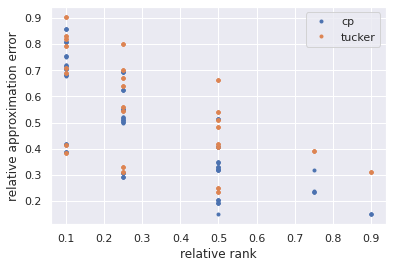

In [16]:
grouped_df = df_rank.groupby('factorization')
ax = grouped_df['error'].plot(legend=True, style=".", ylabel='relative approximation error', xlabel='relative rank')

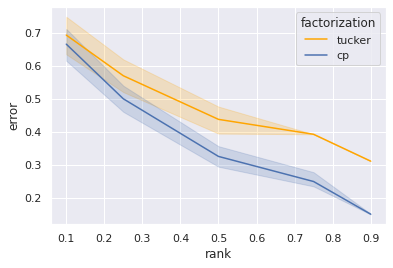

In [17]:
# df = pd.DataFrame(results)
# df['rank'] = df['rank'].astype(float, copy=False)
# Plot the responses for different events and regions
ax = sns.lineplot(x="rank", y="error",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)

<AxesSubplot:xlabel='rank', ylabel='error'>

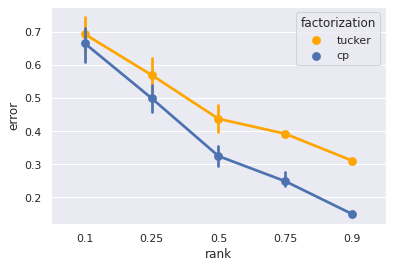

In [18]:
sns.pointplot(x="rank", y="error",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)

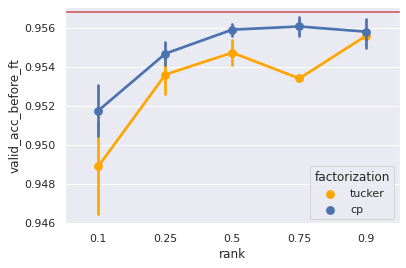

In [19]:
ax = sns.pointplot(x="rank", y="valid_acc_before_ft",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['best_valid_acc'], color='r')

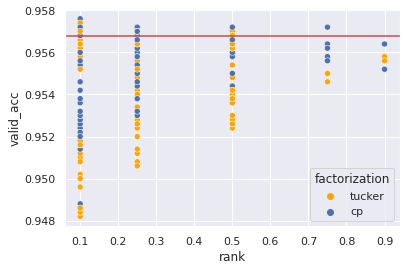

In [20]:
ax = sns.scatterplot(x="rank", y="valid_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['best_valid_acc'], color='r')

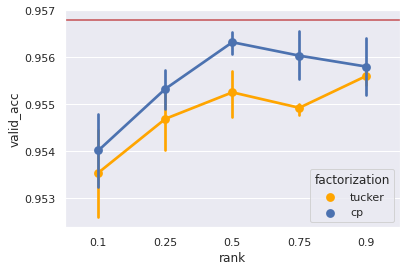

In [21]:
ax = sns.pointplot(x="rank", y="valid_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['best_valid_acc'], color='r')

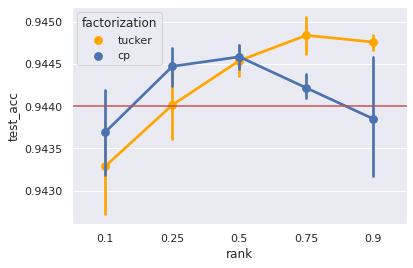

In [22]:
ax = sns.pointplot(x="rank", y="test_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['test_acc'], color='r')

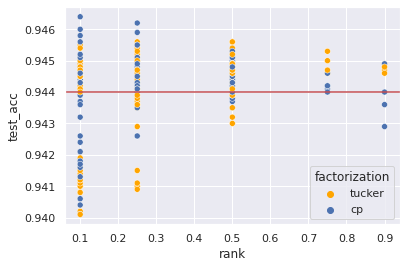

In [23]:
ax = sns.scatterplot(x="rank", y="test_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['test_acc'], color='r')

In [24]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['rank'].plot(legend=True, style=".-", ylabel='relative rank', xlabel='relative approximation error')

In [25]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

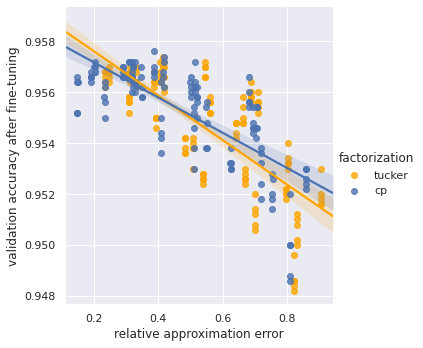

In [26]:
g = sns.lmplot(x="error", y="valid_acc",
    hue="factorization", data=df,
    # y_jitter=.02, 
    # logistic=True, 
    # style="rank",
    truncate=False, palette=['orange', 'b'], 
)
g = g.set(xlabel='relative approximation error', ylabel='validation accuracy after fine-tuning')


In [27]:
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df.head()

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm,fact_rank,fact_layers
0,conv2,38,0.417412,38,tucker,0.50,0.9566,0.9560,10878589,0.9445,0.00001,adam,73.751099,441.326247,4096.0,0.167286,0.018006,tucker-0.5,tucker-38
1,conv1,44,0.320085,44,cp,0.50,0.9566,0.9566,10878297,0.9448,0.00001,adam,69.962518,861.984651,4096.0,0.081277,0.017081,cp-0.5,cp-44
2,conv1,28,0.538858,28,tucker,0.50,0.9528,0.9512,11098445,0.9451,0.00001,adam,118.639486,420.734193,6272.0,0.282127,0.018916,tucker-0.5,tucker-28
3,conv1,28,0.392214,28,tucker,0.75,0.9550,0.9534,11136896,0.9453,0.00001,adam,82.524876,420.734193,6272.0,0.196265,0.013158,tucker-0.75,tucker-28
4,conv2,15,0.548970,15,cp,0.25,0.9538,0.9526,11145261,0.9443,0.00001,adam,84.728561,366.026601,12544.0,0.231576,0.006755,cp-0.25,cp-15


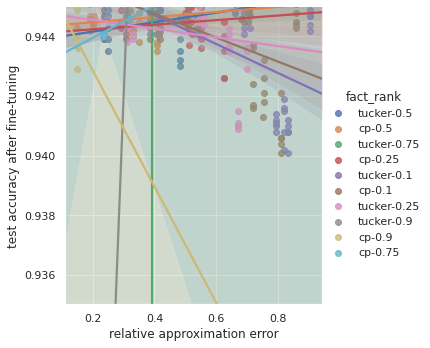

In [28]:
g = sns.lmplot(x="error", y="test_acc", 
   hue="fact_rank", 
   data=df,
   truncate=False, 
   # palette=['orange','b'],
)
g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')
g.set(ylim=(0.935, 0.945))

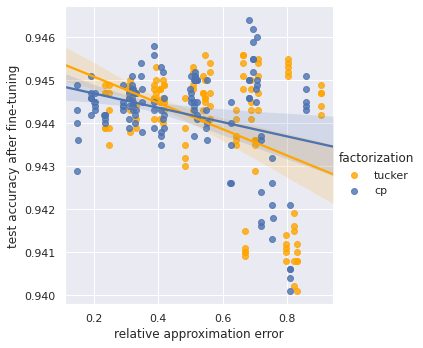

In [29]:
g = sns.lmplot(x="error", y="test_acc", 
   hue="factorization", 
   data=df,
   # logistic=True,
   truncate=False, 
   palette=['orange','b'],
)
g = g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')

In [30]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

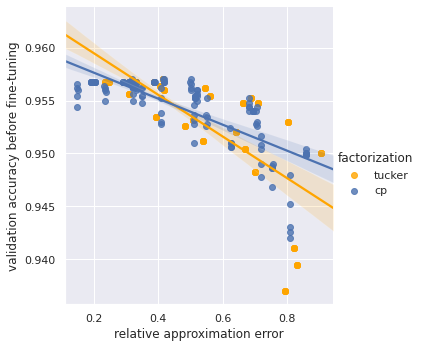

In [31]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

In [32]:
df_layers = pd.DataFrame(results)
df_layers['rank'] = df_layers['rank'].astype(float, copy=False)
df_layers = df_layers.loc[df_layers['rank'] == 0.5]
df_layers

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm
0,conv2,38,0.417412,38,tucker,0.5,0.9566,0.9560,10878589,0.9445,0.00001,adam,73.751099,441.326247,4096.0,0.167286,0.018006
1,conv1,44,0.320085,44,cp,0.5,0.9566,0.9566,10878297,0.9448,0.00001,adam,69.962518,861.984651,4096.0,0.081277,0.017081
2,conv1,28,0.538858,28,tucker,0.5,0.9528,0.9512,11098445,0.9451,0.00001,adam,118.639486,420.734193,6272.0,0.282127,0.018916
5,conv2,15,0.508273,15,tucker,0.5,0.9538,0.9532,11154645,0.9453,0.00001,adam,99.056845,366.026601,12544.0,0.270698,0.007897
9,0,41,0.661809,41,tucker,0.5,0.9548,0.9548,11156556,0.9456,0.00001,adam,59.461849,134.730559,4096.0,0.441798,0.014517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,conv1,60,0.248301,60,tucker,0.5,0.9564,0.9568,9995872,0.9449,0.00001,adam,36.333462,1497.369205,2048.0,0.024424,0.017741
251,conv1,28,0.408988,28,cp,0.5,0.9564,0.9552,11099257,0.9443,0.00001,adam,73.881649,420.734193,6272.0,0.175713,0.011780
254,conv1,44,0.405947,44,tucker,0.5,0.9564,0.9564,10878589,0.9441,0.00001,adam,114.326228,861.984651,4096.0,0.132776,0.027912
255,conv1,44,0.318756,44,cp,0.5,0.9566,0.9564,10878297,0.9448,0.00001,adam,70.036598,861.984651,4096.0,0.081364,0.017099


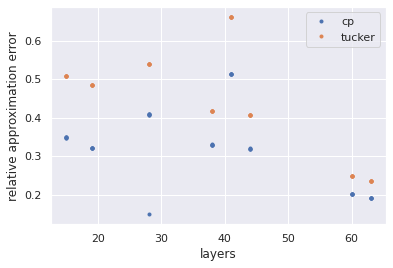

In [33]:
df_layers_idx = df_layers.set_index('layers', inplace=False)
grouped_df_layers = df_layers_idx.groupby('factorization')
ax = grouped_df_layers['error'].plot(legend=True, style=".", ylabel='relative approximation error')

In [34]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('layers', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['error'].plot(legend=True, style=".-", ylabel='relative approximation error')

# ax = grouped_df_layers['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

In [35]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('error', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

<AxesSubplot:xlabel='layers', ylabel='error'>

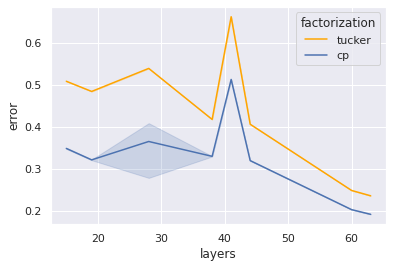

In [36]:
# df = pd.DataFrame(results)
# df['rank'] = df['rank'].astype(float, copy=False)

# Plot the responses for different events and regions
sns.lineplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             )

<AxesSubplot:xlabel='layers', ylabel='error'>

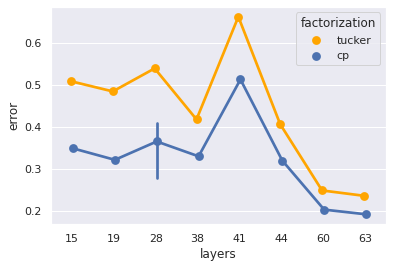

In [37]:
sns.pointplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             dodge=True
             )

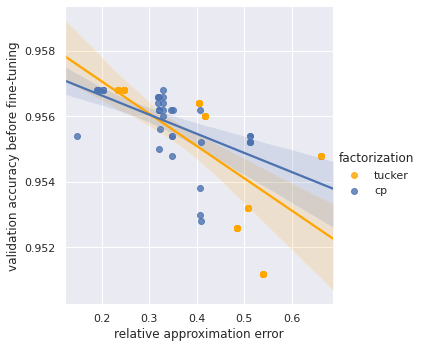

In [38]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

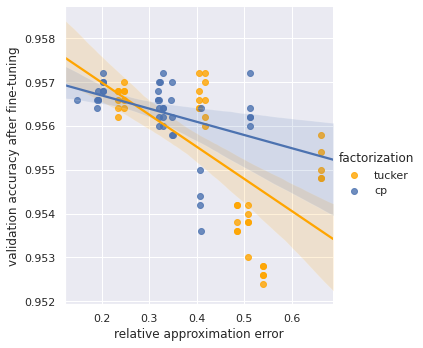

In [39]:
g = sns.lmplot(x="error", y="valid_acc", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy after fine-tuning')

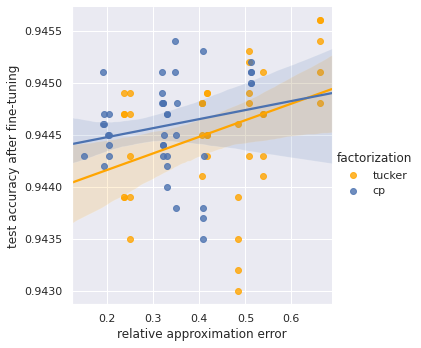

In [40]:
g = sns.lmplot(x="error", y="test_acc", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')

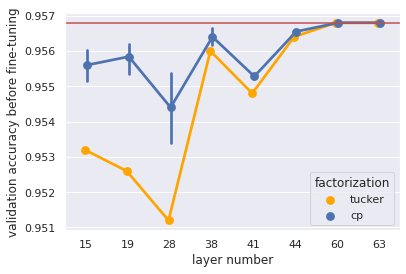

In [41]:
ax = sns.pointplot(x="layers", y="valid_acc_before_ft",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax = ax.set(xlabel='layer number', ylabel='validation accuracy before fine-tuning')

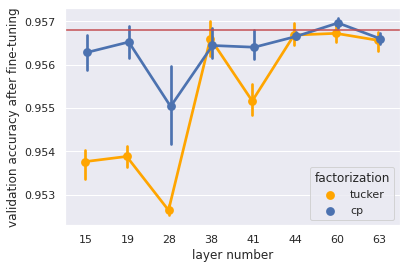

In [42]:
ax = sns.pointplot(x="layers", y="valid_acc",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax = ax.set(xlabel='layer number', ylabel='validation accuracy after fine-tuning')


[Text(0.5, 0, 'layer number'), Text(0, 0.5, 'test accuracy after fine-tuning')]

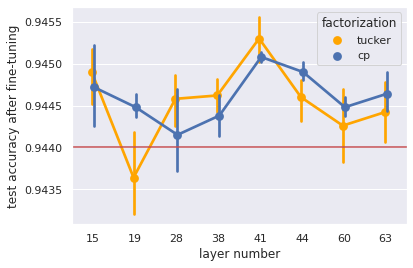

In [43]:
ax = sns.pointplot(x="layers", y="test_acc",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             dodge=True)
ax.axhline(baseline_result['test_acc'], color='r')
ax.set(xlabel='layer number', ylabel='test accuracy after fine-tuning')

In [44]:
df.factorization.isna()

0      False
1      False
2      False
3      False
4      False
       ...  
255    False
256    False
257    False
258    False
259    False
Name: factorization, Length: 260, dtype: bool

In [45]:
df[df.error.isnull()]

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm,fact_rank,fact_layers


In [46]:
df_layer_rank = df.groupby(['factorization','layers','rank'])
df_std = df_layer_rank[['valid_acc','test_acc']].std()

print(df_std.to_latex())

\begin{tabular}{lllrr}
\toprule
       &    &      &  valid\_acc &  test\_acc \\
factorization & layers & rank &            &           \\
\midrule
cp & 15 & 0.10 &   0.000576 &  0.000731 \\
       &    & 0.25 &   0.000856 &  0.000532 \\
       &    & 0.50 &   0.000522 &  0.000614 \\
       & 19 & 0.10 &   0.000841 &  0.001007 \\
       &    & 0.25 &   0.001000 &  0.000466 \\
       &    & 0.50 &   0.000460 &  0.000192 \\
       & 28 & 0.10 &   0.001354 &  0.000777 \\
       &    & 0.25 &   0.000329 &  0.000844 \\
       &    & 0.50 &   0.001223 &  0.000650 \\
       &    & 0.75 &   0.000548 &  0.000089 \\
       &    & 0.90 &   0.000693 &  0.000835 \\
       & 38 & 0.10 &   0.000537 &  0.000568 \\
       &    & 0.25 &   0.000438 &  0.000428 \\
       &    & 0.50 &   0.000456 &  0.000311 \\
       & 41 & 0.10 &   0.000358 &  0.000327 \\
       &    & 0.25 &   0.000385 &  0.000391 \\
       &    & 0.50 &   0.000469 &  0.000084 \\
       & 44 & 0.10 &   0.000477 &  0.000743 \\
       &  

In [47]:
!pwd

/home/jetzeschuurman/gitProjects/phd/tddl/notebooks/results


In [156]:
# df.to_json("/home/jetzeschuurman/gitProjects/phd/tddl/artifacts/f_mnist/std_adam.json")

# Relevant Plots

In [94]:
!pwd

/home/jetzeschuurman/gitProjects/phd/tddl/notebooks/results


In [96]:
limits = (0.935, 0.96)

plot_dir = Path("/home/jetzeschuurman/gitProjects/phd/tddl/plots/fmnist/norm_acc")

## Analysis on the weights


### Relative norm on weights

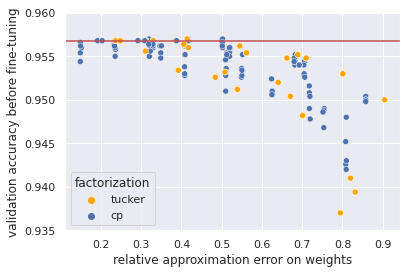

In [102]:
ax = sns.scatterplot(
    x="error", y="valid_acc_before_ft", 
    hue="factorization", 
    data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy before fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=limits)
fig = ax.get_figure()
fig.savefig(plot_dir / "fmnist_rn18_weight-rel-norm_valid-before")

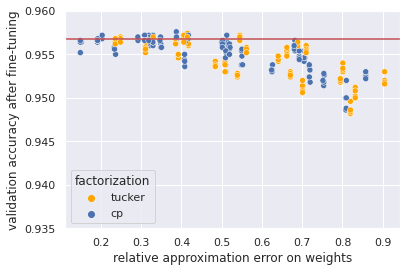

In [101]:
ax = sns.scatterplot(x="error", y="valid_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'], 
)
ax.set(
    xlabel='relative approximation error on weights', 
    ylabel='validation accuracy after fine-tuning',
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=limits)
fig = ax.get_figure()
fig.savefig(plot_dir / "fmnist_rn18_weight-rel-norm_valid-after")

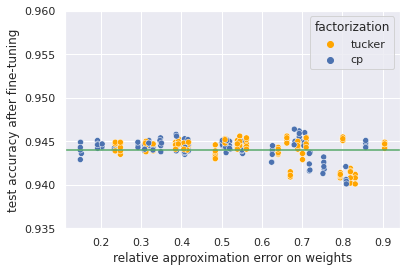

In [100]:
ax = sns.scatterplot(x="error", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='relative approximation error on weights', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=limits)
fig = ax.get_figure()
fig.savefig(plot_dir / "fmnist_rn18_weight-rel-norm_test-after")

## Analysis on the features space

### Relative Norm

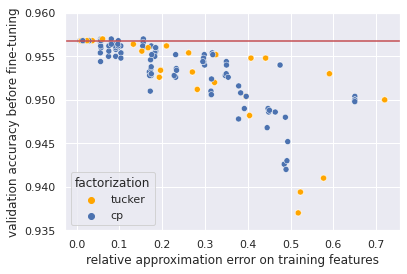

In [103]:
ax = sns.scatterplot(
    x="relative_norm", y="valid_acc_before_ft", 
    hue="factorization", 
    data=df,
    palette=['orange', 'b'], 
)
ax.set(
    xlabel='relative approximation error on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=limits)
fig = ax.get_figure()
fig.savefig(plot_dir / "fmnist_rn18_feat-rel-norm_valid-before")

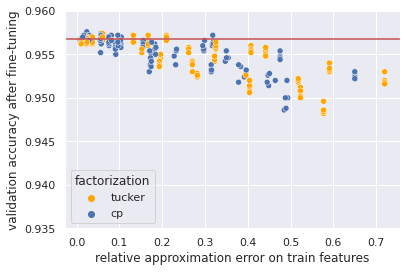

In [104]:
ax = sns.scatterplot(x="relative_norm", y="valid_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'], 
)
ax.set(
    xlabel='relative approximation error on train features', 
    ylabel='validation accuracy after fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=limits)
fig = ax.get_figure()
fig.savefig(plot_dir / "fmnist_rn18_feat-rel-norm_valid-after")

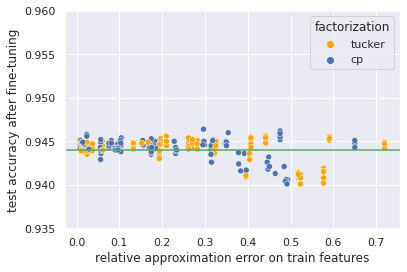

In [105]:
ax = sns.scatterplot(x="relative_norm", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(
    xlabel='relative approximation error on train features', 
    ylabel='test accuracy after fine-tuning',
)
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=limits)
fig = ax.get_figure()
fig.savefig(plot_dir / "fmnist_rn18_feat-rel-norm_test-after")

### Scaled Norm

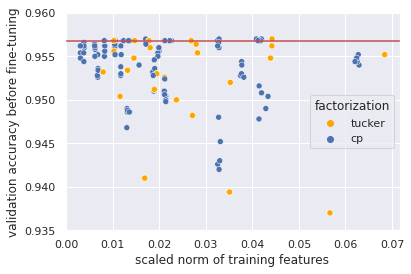

In [106]:
ax = sns.scatterplot(
    x="scaled_norm", y="valid_acc_before_ft", 
    hue="factorization", 
    data=df,
    palette=['orange', 'b'], 
)
ax.set(
    xlabel='scaled norm of training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=limits)
fig = ax.get_figure()
fig.savefig(plot_dir / "fmnist_rn18_feat-scaled-norm_valid-before")

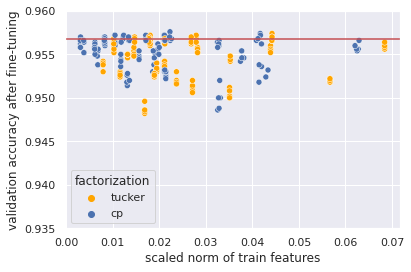

In [107]:
ax = sns.scatterplot(x="scaled_norm", y="valid_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'], 
)
ax.set(
    xlabel='scaled norm of train features', 
    ylabel='validation accuracy after fine-tuning',
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=limits)
fig = ax.get_figure()
fig.savefig(plot_dir / "fmnist_rn18_feat-scaled-norm_valid-after")

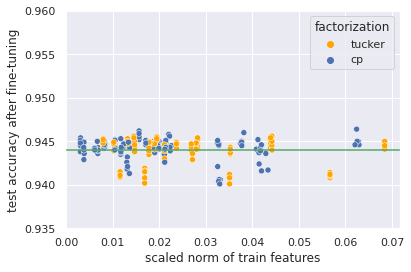

In [108]:
ax = sns.scatterplot(x="scaled_norm", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='scaled norm of train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=limits)
fig = ax.get_figure()
fig.savefig(plot_dir / "fmnist_rn18_feat-scaled-norm_test-after")

### Norm of Difference

In [109]:
import numpy as np
df['log_norm_diff'] = np.log(df.norm_diff)

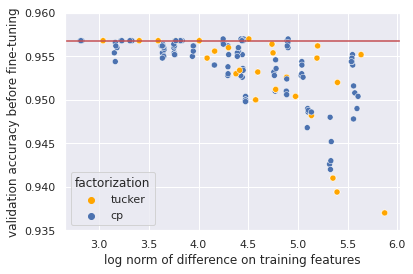

In [110]:
ax = sns.scatterplot(
    x="log_norm_diff", y="valid_acc_before_ft", 
    hue="factorization", 
    data=df,
    palette=['orange', 'b'], 
)
ax.set(
    xlabel='log norm of difference on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=limits)
fig = ax.get_figure()
fig.savefig(plot_dir / "fmnist_rn18_feat-norm-diff_valid-before")

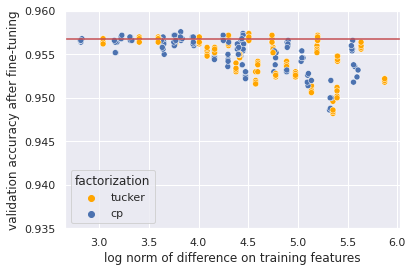

In [111]:
ax = sns.scatterplot(x="log_norm_diff", y="valid_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'], 
)
ax.set(
    xlabel='log norm of difference on training features', 
    ylabel='validation accuracy after fine-tuning',
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=limits)
fig = ax.get_figure()
fig.savefig(plot_dir / "fmnist_rn18_feat-norm-diff_valid-after")

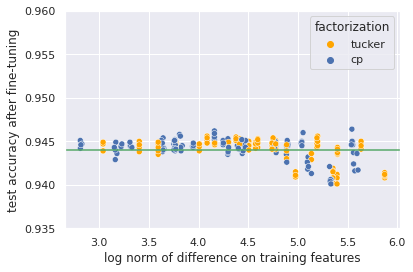

In [112]:
ax = sns.scatterplot(x="log_norm_diff", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(
    xlabel='log norm of difference on training features', 
    ylabel='test accuracy after fine-tuning'
)
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=limits)
fig = ax.get_figure()
fig.savefig(plot_dir / "fmnist_rn18_feat-norm-diff_test-after")

In [15]:
replacements = {
    'valid_acc_before_ft': "Validation accuracy before fine-tuning", 
    'valid_acc': "Validation accuracy after fine-tuning",
    'test_acc': "Test accuracy after fine-tuning", 
    'error': 'Relative norm on weights',
    'relative_norm': 'Relative norm on training features',
    'scaled_norm': 'Scaled norm on training features',
    'norm_diff': 'Norm of the difference between training features',
    'log_norm_diff': 'Log norm of the difference between training features',
}

KeyError: 'log_norm_diff'

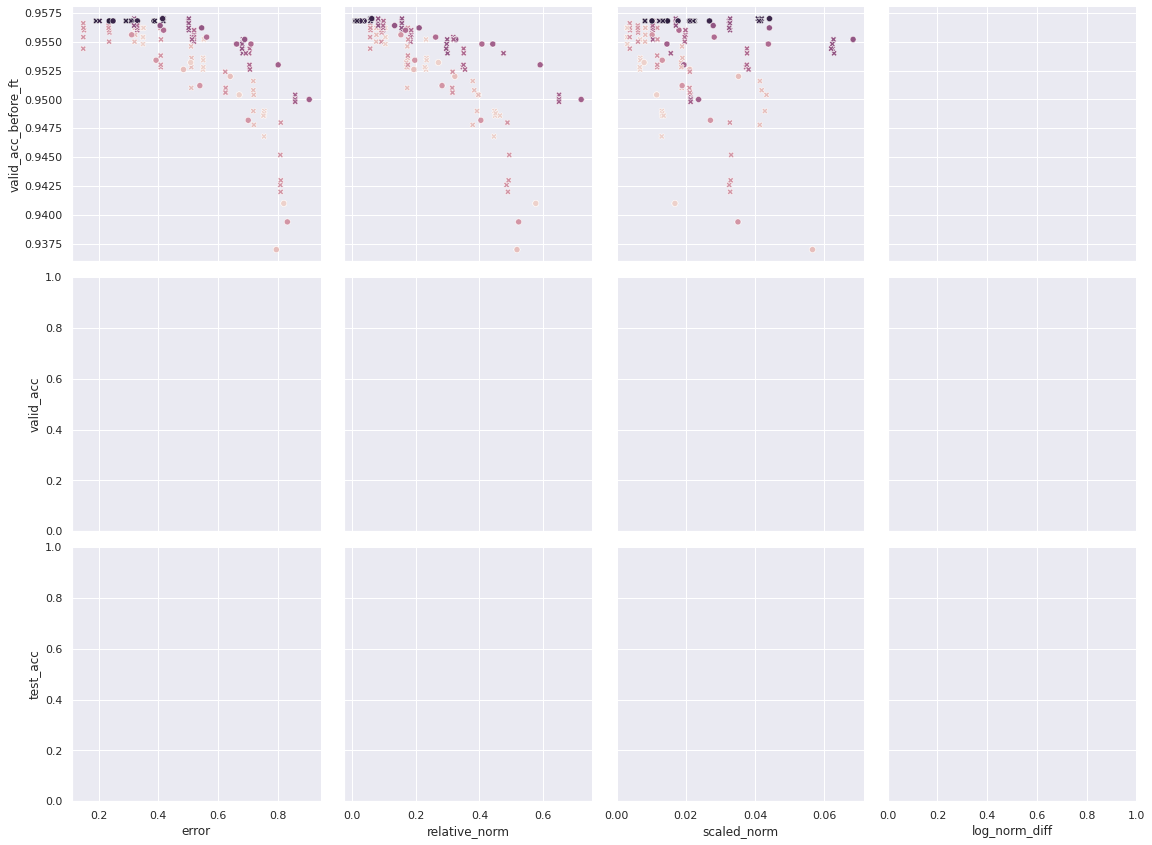

In [16]:
from matplotlib import pyplot as plt 

g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"log_norm_diff"],
    height=4,
)
g.map(lambda x, y, **kwargs: sns.scatterplot(x=x,y=y,hue=df.layers,style=df.factorization,legend='auto')) # color=".3")
g.set(ylim=(0.86,0.925))
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
plt.legend(
    bbox_to_anchor=(1.05, 1,1,1),
    loc='upper left', borderaxespad=0.
    # loc='right',
    # bbox_to_anchor=(1.1, 0.5, 0, 0),
)
# g.fig.get_children()[-1].set_bbox_to_anchor((1.1, 0.5, 0, 0))

# g.savefig("../../plots/fmnist/rn18/scatter_errors_performances_layers_factorizations")